In [3]:
#!pip install -U hopsworks --quiet

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns
import hopsworks

In [15]:
project = hopsworks.login()
fs = project.get_feature_store()

try: 
    feature_view = fs.get_feature_view(name="mag_feature", version=1)
except:
    mag_fg = fs.get_feature_group(name="mag_feature", version=1)
    query = mag_fg.select_all()
    feature_view = fs.create_feature_view(name="mag_feature",
                                      version=1,
                                      description="Read from Magnetic field dataset",
                                      labels=["mag_cluster"],
                                      query=query)

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/549014
Connected. Call `.close()` to terminate connection gracefully.
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/549014/fs/544837/fv/mag_feature/version/1


In [16]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)


Finished: Reading data from Hopsworks, using ArrowFlight (1.28s) 


In [17]:
y_train

,mag_cluster
0,detection
2,detection
3,detection
4,detection
5,detection
...,...
20401,no_detection
20404,detection
20406,detection
20407,detection


In [18]:
model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=2)

In [19]:
y_pred = model.predict(X_test)
y_pred

array(['detection', 'detection', 'detection', ..., 'detection',
       'no_detection', 'no_detection'], dtype=object)

In [20]:
from sklearn.metrics import classification_report

metrics = classification_report(y_test, y_pred, output_dict=True)
print(metrics)

{'detection': {'precision': 0.9992864787727435, 'recall': 1.0, 'f1-score': 0.9996431120628123, 'support': 2801.0}, 'no_detection': {'precision': 1.0, 'recall': 0.9984387197501952, 'f1-score': 0.99921875, 'support': 1281.0}, 'accuracy': 0.9995100440960314, 'macro avg': {'precision': 0.9996432393863717, 'recall': 0.9992193598750976, 'f1-score': 0.9994309310314062, 'support': 4082.0}, 'weighted avg': {'precision': 0.9995103936899692, 'recall': 0.9995100440960314, 'f1-score': 0.9995099401366824, 'support': 4082.0}}


In [21]:
from sklearn.metrics import confusion_matrix

results = confusion_matrix(y_test, y_pred)
print(results)

[[2801    0]
 [   2 1279]]


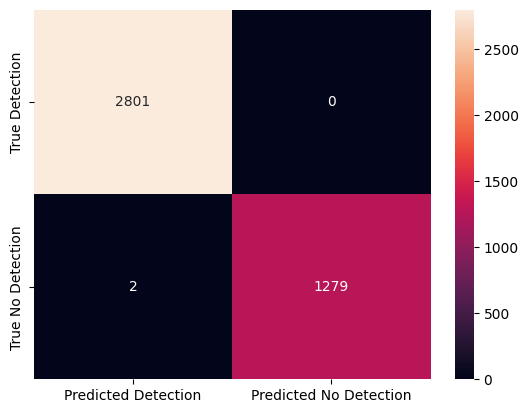

In [22]:
from matplotlib import pyplot

df_cm = pd.DataFrame(results, ['True Detection', 'True No Detection'],
                     ['Predicted Detection', 'Predicted No Detection'])

cm = sns.heatmap(df_cm, annot=True, fmt='g')

fig = cm.get_figure()
fig.savefig("/workspaces/MLOps_Project/pictures/confusion_matrix.png") 
fig.show()

In [23]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import os
import joblib
import hopsworks
import shutil

project =  hopsworks.login()
mr = project.get_model_registry()

# The 'iris_model' directory will be saved to the model registry
model_dir="mag_detection_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)
joblib.dump(model, model_dir + "/mag_detection_model.pkl")
shutil.copyfile("/workspaces/MLOps_Project/pictures/confusion_matrix.png", model_dir + "/confusion_matrix.png")

input_example = X_train.sample()
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

mag_detection_model = mr.python.create_model(
    version=1,
    name="mag_feature", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    input_example=input_example, 
    description="Magnetic Detections predictor",)

mag_detection_model.save(model_dir)

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/549014
Connected. Call `.close()` to terminate connection gracefully.


Uploading: 100.000%|██████████| 1128742/1128742 elapsed<00:03 remaining<00:003.36it/s]
Uploading: 100.000%|██████████| 19482/19482 elapsed<00:01 remaining<00:001,  3.36it/s]
Uploading: 100.000%|██████████| 23/23 elapsed<00:01 remaining<00:0005<00:13,  3.46s/it]
Uploading: 100.000%|██████████| 378/378 elapsed<00:01 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:14<00:00,  2.42s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/549014/models/mag_feature/1


Model(name: 'mag_feature', version: 1)